# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


from loguru import logger

In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [5]:
# Sua análise começa aqui.
# Exinbindo quantidade de entradas e variáveis
print(f"Entradas: \t{fifa.shape[0]}")
print(f"Variáveis: \t{fifa.shape[1]}")


Entradas: 	18207
Variáveis: 	37


In [6]:
#  Exinbindo 5 primeiras linhas do dataset
fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [7]:

# Criando um dataframe para consolidar informações que facilitem a análise dos dados
fifa_info = pd.DataFrame({'Colunas': fifa.columns,
                     'Tipo': fifa.dtypes,
                     ' % Missing values': round((fifa.isna().sum() / fifa.shape[0]) * 100,2)
                    })
fifa_info.reset_index(drop=True)

,Colunas,Tipo,% Missing values
0,Age,int64,0.00
1,Overall,int64,0.00
2,Potential,int64,0.00
3,Crossing,float64,0.26
4,Finishing,float64,0.26
5,HeadingAccuracy,float64,0.26
6,ShortPassing,float64,0.26
7,Volleys,float64,0.26
8,Dribbling,float64,0.26
9,Curve,float64,0.26


Percebemos que, embora em percentual muito pequeno, possuímos valores ausentes no dataset, dessa forma iremos excluí-los para podermos aplicar o PCA.

In [8]:
# Removendo as linhas que possuem NaN
fifa = fifa.dropna()

print(f"Entradas: \t {fifa.shape[0]}") 

Entradas: 	 18159


# Redução de Dimensionalidade

Uma das técnicas utilizadas para redução de dimensionalidade é o *Principal Component Analysis* **(PCA)**, com o PCA ẽ possĩvel reduzir a dimensionalidade de um dataset aumentando sua interpretabilidade, mas ao mesmo tempo minimizando a perda de informação.

O PCA nos mostra a quantidade que de componentes que consegue explicar um percentual definido de variância dos dados.

Abaixo podemos ver o método "Elbow" que traz um acumulado da variância conforme a quantidade de componentes.

In [9]:
pca_095 = PCA(n_components = 0.95).fit_transform(fifa)
print(f"Componentes: \t {pca_095.shape[1]}")

Componentes: 	 15


Abaixo podemos ver o método "Elbow" quer traz um acumulado da variância conforme a quantidade de componentes.

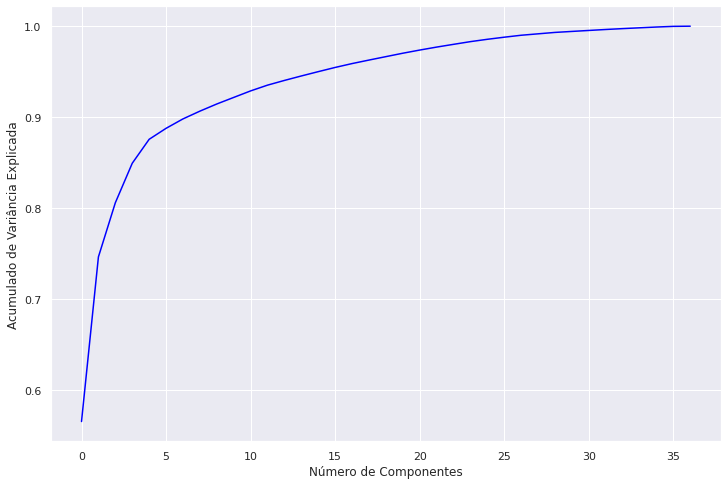

In [10]:
pca = PCA().fit(fifa)

plt.plot(np.cumsum(pca.explained_variance_ratio_), color="blue")
plt.xlabel("Número de Componentes")
plt.ylabel("Acumulado de Variância Explicada");



A linha pontilhada em vermelho representa 95% de variância e ele se cruza com a curva azul quando se tem 14 componentes, o que nos permite ver uma redução de 37 para 14 dimensões.

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [11]:
def q1():
    # Retorne aqui o resultado da questão 1.
  
    # Obtendedo atráves do PCA qual é a o percentual de variância explicada por 1 componente
    pca_1_componente = PCA(n_components=1).fit(fifa)
  
    # Retornando o percentual de variância explicado pelo componente 1
    return round(float(pca_1_componente.explained_variance_ratio_),3)
q1()

0.565

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [12]:
def q2():
    # Retorne aqui o resultado da questão 2.
    # Calculado anteriormente na explicação do PCA
    return pca_095.shape[1]
q2()

15

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [13]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [14]:
def q3():
    # Retorne aqui o resultado da questão 3.
    # Aplicando o PCA para 2 componentes
    pca_2 = PCA(n_components=2).fit(fifa)
    
    # Através da mulplicação dos autovetores dos componentes 1 e 2 pelo vetor X chegamos nas coordenadas projetadas para o vetor X em relação aos componentes 1 e 2
    coordenadas = pca_2.components_.dot(x).round(3)
    
    # Retornando as coordenadas
    return tuple(coordenadas)
q3()

(186.556, -6.592)

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [15]:
def q4():
    # Retorne aqui o resultado da questão 4.
    # Definindo as variáveris preditoras
    X = fifa.drop("Overall", axis=1)
   
    # Definindo a variável predita
    y = fifa["Overall"]
  
    # Instanciando o RFE  (Recursive Feature Elimination) para uma regressão linear
    estimator = RFE(LinearRegression(),n_features_to_select=5).fit(X,y)

    # Retornando o nome das variáveis
    return [i[1] for i in zip(estimator.support_, X.columns) if i[0]]
q4()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']